# Lab 01 AB

## Data Evaluation
- movies.csv contains ~2k movies 

### Usable Features (Known before movie release):
- budget (Numeric): does high budget lead to reviews? 
- runtime (Numeric): are longer movies generally better? 
- genres (Categorical $\rightarrow$ One-Hot): horror, action, drama, romance ...
- production_companies (Categorical): pixar, disney, ...
- release_month (Temporal): seasonal timing
- release_year (Temporal)
- overview (Text -> TF-IDF): plot depth
- tagline (Text -> TF-IDF): marketing tone 
- keywords (Text -> Count + TF-IDF): specific topics
- status (Categorical): released, post production

### Leaky Featues
- revenue (Leakage: box office correlates with popularity)
- vote_count (Leakage: popularity proxy)
- popularity (Leakage)
- adult (Useless: all values are False).
- original_language (Useless: all are en)

In [18]:
import pandas as pd
import matplotlib as plt
import sklearn

df = pd.read_csv("movies.csv")
df.head()

,id,imdb_id,original_title,adult,backdrop_path,budget,homepage,original_language,overview,popularity,...,vote_count,collection_id,collection_name,origin_country,genres,genre_ids,production_companies,production_countries,spoken_languages,keywords
0,1228246,tt30274401,Five Nights at Freddy's 2,False,/54BOXpX2ieTXMDzHymdDMnUIzYG.jpg,36000000,https://www.fivenightsatfreddys.movie,en,One year since the supernatural nightmare at F...,381.5918,...,355,1240438.0,Five Nights at Freddy's Collection,US,Horror|Thriller,27|53,Blumhouse Productions|Scott Cawthon Production...,United States of America,English,killer robot|pizzeria|sequel|serial killer|sec...
1,813,tt0080339,Airplane!,False,/lz6Cy1JgOR72AilU2ghDvLKbgqT.jpg,3500000,NaN,en,An ex-fighter pilot forced to take over the co...,12.1936,...,4880,91663.0,Airplane Collection,US,Comedy,35,Paramount Pictures|Howard W. Koch Productions,United States of America,English,"chicago, illinois|post-traumatic stress disord..."
2,1891,tt0080684,The Empire Strikes Back,False,/aJCtkxLLzkk1pECehVjKHA2lBgw.jpg,18000000,http://www.starwars.com/films/star-wars-episod...,en,"The epic saga continues as Luke Skywalker, in ...",8.5016,...,17951,10.0,Star Wars Collection,US,Adventure|Action|Science Fiction,12|28|878,Lucasfilm Ltd.,United States of America,English,rebellion|android|spacecraft|asteroid|rebel|sp...
3,694,tt0081505,The Shining,False,/mmd1HnuvAzFc4iuVJcnBrhDNEKr.jpg,19000000,https://www.warnerbros.com/movies/shining,en,Jack Torrance accepts a caretaker job at the O...,13.7163,...,18468,530064.0,The Shining Collection,US,Horror|Thriller,27|53,Warner Bros. Pictures|Peregrine|Hawk Films|The...,United Kingdom|United States of America,English,hotel|new year's eve|child abuse|based on nove...
4,4488,tt0080761,Friday the 13th,False,/16zzKM5vDxnYiqG6Tg6wOkOLSmj.jpg,550000,NaN,en,Camp counselors are stalked and murdered by an...,6.6688,...,3213,9735.0,Friday the 13th Collection,US,Horror,27,Sean S. Cunningham Films|Georgetown Productions,United States of America,English,lake|new jersey|drowning|summer camp|sadism|vi...


## Data Quality Audit

In [19]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
print(missing_pct[missing_pct > 0].sort_values(ascending=False).to_string())

collection_id           61.2
collection_name         61.2
homepage                41.2
tagline                  3.4
keywords                 1.6
backdrop_path            0.9
production_companies     0.4
production_countries     0.4
poster_path              0.3
spoken_languages         0.3
origin_country           0.2
imdb_id                  0.1


In [20]:
print(f"Exact duplicates: {df.duplicated().sum()}")
print(f"Duplicate IDs: {df['id'].duplicated().sum()}")
print(f"Duplicate titles: {df['title'].duplicated().sum()} (remakes OK)")

Exact duplicates: 0
Duplicate IDs: 0
Duplicate titles: 37 (remakes OK)


count    2226.00
mean        6.70
std         1.12
min         0.00
25%         6.30
50%         6.84
75%         7.33
max         8.70
Name: vote_average, dtype: float64

Skew: -2.92


<Axes: >

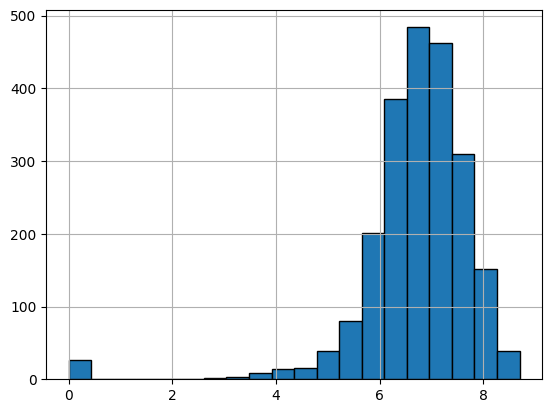

In [21]:
print(df['vote_average'].describe().round(2))
print(f"\nSkew: {df['vote_average'].skew():.2f}")
df['vote_average'].hist(bins=20, edgecolor='black')

### Bias Note
**Budget-quality correlation**: High-budget films have more votes/metadata. Models may underperform on indie films.

## Leakage-Safe Split
**Time-based split** (train: <2020, test: 2020+) — simulates real prediction, prevents temporal/franchise leakage.

In [22]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

train_df = df[df['release_year'] < 2020].copy()
test_df = df[df['release_year'] >= 2020].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.0f}%) | {train_df['release_year'].min()}-{train_df['release_year'].max()}")
print(f"Test:  {len(test_df)} ({len(test_df)/len(df)*100:.0f}%) | {test_df['release_year'].min()}-{test_df['release_year'].max()}")

Train: 1869 (84%) | 1903-2019
Test:  357 (16%) | 2020-2026


## Preprocessing Pipeline
ColumnTransformer for mixed types: numeric (scale) + categorical (one-hot). Fit on train only.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# feature groups
num_features = ['budget', 'runtime', 'release_year']
cat_features = ['genres']  

for d in [train_df, test_df]:
    d['genres'] = d['genres'].fillna('Unknown').str.split('|').str[0]

# transform data to fit our needs
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# fit on training and transform both
X_train = train_df[num_features + cat_features]
X_test = test_df[num_features + cat_features]
y_train = train_df['vote_average']
y_test = test_df['vote_average']

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"X_train shape: {X_train_transformed.shape}")
print(f"X_test shape:  {X_test_transformed.shape}")
print(f"Features: {num_features} + {len(preprocessor.named_transformers_['cat']['onehot'].categories_[0])} genre categories")

X_train shape: (1869, 21)
X_test shape:  (357, 21)
Features: ['budget', 'runtime', 'release_year'] + 18 genre categories
